# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 3. Детекция объектов. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

### Консультация 2023 года

https://www.youtube.com/watch?v=oCwEmKW3bYg

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом. На Windows, скорее всего, вас ждет немало проблем :(

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
# !wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip


In [6]:
import glob
import shutil
from pathlib import Path
from xml.etree import ElementTree as ET

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import ultralytics
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib.patches import Rectangle
from PIL import Image
from torch import nn
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm

In [ ]:
!unzip -q data.zip

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        # то есть res выглядит как [xmin, ymin, xmax, ymax, class]
        # всё в int!
        # Для корректной работы клеточек ниже требуется конкретная последовательность координат
        # См. доку https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
        # Нас интересует pascal_voc формат, далее применяется он.
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)
        cls_name = member.find("name").text
        
        cls_id = class_dict[cls_name]
        res =  [xmin, ymin, xmax, ymax, cls_id]

        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        # Нужно обладая файлнеймом подгрузить картинку и бибоксы, функцию для подгрузки бибоксов вы дописали выше :)
        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))        
        bboxes = get_xml_data(fname, self.root, self.class_dict)
        
        # transform будут объявлены ниже за вас
        # Но библиотека привередлива к формату данных на входе, внимательно прочтите прошлую клеточку
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [9]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Вот тут мы говорим что хотим pascal_voc
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [10]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [106]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv

        # Вот тут покажите картинку после отката нормализации
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = std * img + mean
        ax.imshow(img)

        for bbox in bboxes[i]:
            x_min, y_min, x_max, y_max, cls_id = bbox
            width = x_max - x_min
            height = y_max - y_min

            rect = patches.Rectangle(
                (x_min, y_min),
                width,
                height,
                linewidth=2,
                edgecolor="g",
                facecolor="none"
            )
            # добавляем бокс на картинку
            ax.add_patch(rect)
            
            ax.text(
                x_min,
                y_min,
                train_ds.class_dict_inv[int(cls_id)],
                color="white",
                fontsize=8,
            )

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://i.imgur.com/V5TUT26.png)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9999999964237213].


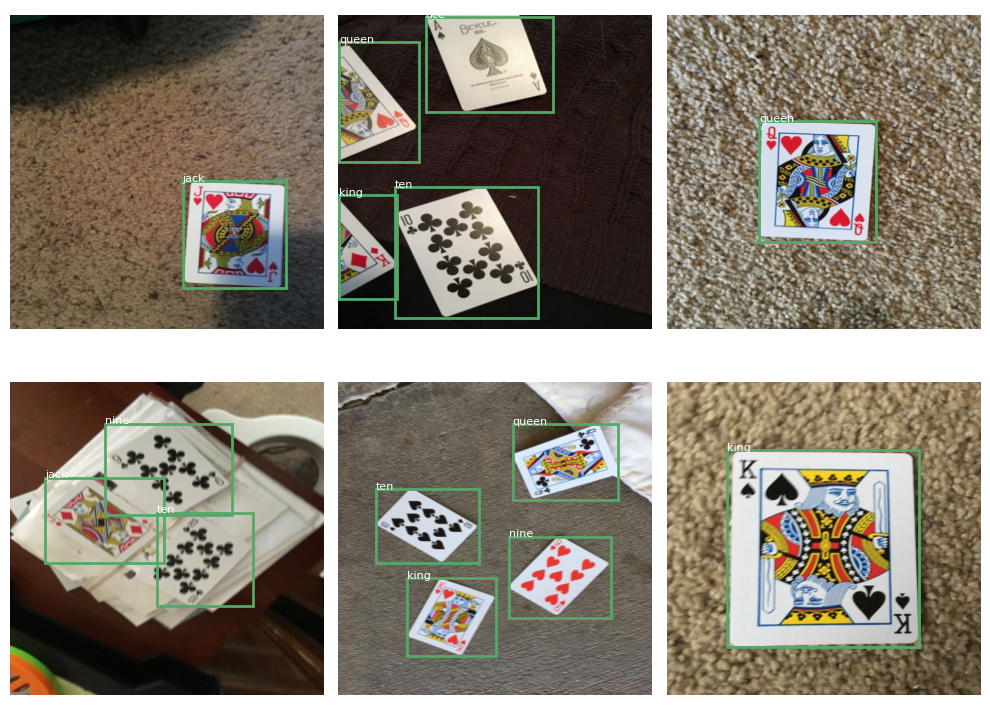

In [107]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и вернуть тензор размера Bx6x16x16. Первая размерность - это количество примеров в батче. Вторая -- "каналы", суть которых написана чуть ниже. Далее идут две пространственные размерности, это сетка 16 на 16. Зафиксируем порядок координат как (y, x) для этой сетки 16 на 16. Это значит, что в target идут ```cy_idx, cx_idx``` в таком порядке, см. код. 

В шести "каналах" у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "гиперпиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

### Пояснительная картинка.

Она обладает некоторым уровнем абстракции, чёрных например должно быть 512, а зелёная должна захватывать 32 маленькие черные. Но может будет понятнее :)

![image](https://i.imgur.com/13YVxAd.jpeg)

In [108]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        # размер клетки по X в пикс
        # размер клетки по Y в пикс
        x_cell = w / (h // downsample)
        y_cell = h / (w // downsample)
        
        # ширина и высота бибокса могут превышать размеры гиперпикселя
        # поэтому их мы нормируем на полноценные 512
        w_box = (xmax - xmin) / w
        h_box = (ymax - ymin) / h

        # Посчитайте координаты центра и сдвиги
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2
        # индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки
        cx_idx = (cx / x_cell).int()
        cy_idx = (cy / y_cell).int()

        # сдивиги относительно cx_idx.
        cx_box = (cx - cx_idx.float() * x_cell) / x_cell
        cy_box = (cy - cy_idx.float() * y_cell) / y_cell

        # cy_idx, потом cx_idx
        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [110]:
def test_collate_fn() -> None:
    target1 = [100, 200, 200, 300, 2]  # xmin, ymin, xmax, ymax, class
    target2_1 = [0, 250, 200, 300, 0]  # xmin, ymin, xmax, ymax, class
    target2_2 = [0, 100, 100, 300, 1]  # xmin, ymin, xmax, ymax, class

    result = collate_fn(
        [
            {"image": torch.rand((3, 512, 512)), "bboxes": [target1]},
            {"image": torch.rand((3, 512, 512)), "bboxes": [target2_1, target2_2]},
        ]
    )

    # Проверяем размерности
    assert result["image"].shape == (2, 3, 512, 512)
    assert result["target"].shape == (2, 6, 16, 16)

    # Проверяем значения клеточек, в которые попали ббоксы
    assert np.allclose(
        result["target"][0, :, 7, 4],
        torch.tensor([22 / 32, 26 / 32, 100 / 512, 100 / 512, 1, 2]),
    )
    assert np.allclose(
        result["target"][1, :, 8, 3],
        torch.tensor([4 / 32, 19 / 32, 200 / 512, 50 / 512, 1, 0]),
    )
    assert np.allclose(
        result["target"][1, :, 6, 1],
        torch.tensor([18 / 32, 8 / 32, 100 / 512, 200 / 512, 1, 1]),
    )

    # Проверяем, что все остальные клеточки содержат нули
    result["target"][0, :, 7, 4] = result["target"][1, :, 8, 3] = result["target"][
        1, :, 6, 1
    ] = torch.zeros(6)
    assert np.allclose(result["target"], 0)


test_collate_fn()

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

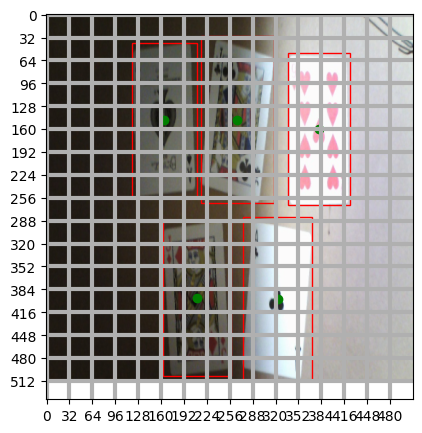

In [90]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx6x16x16. Почему? 

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами. 

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [93]:
from typing import List
def decode_prediction(pred, upsample=32, threshold=0.7) -> List[List[List[float]]]:
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    result = []
    for batch_idx in range(b):
        boxes_in_batch = []
        for y in range(h):
            for x in range(w):
                confidence = pred[batch_idx, 4, y, x]
                if confidence < threshold:
                    continue
                
                cx = x * upsample + pred[batch_idx, 0, y, x] * upsample
                cy = y * upsample + pred[batch_idx, 1, y, x] * upsample
                
                w_box = pred[batch_idx, 2, y, x] * img_w
                h_box = pred[batch_idx, 3, y, x] * img_h
                
                xmin = cx - w_box / 2
                xmax = cx + w_box / 2
                ymin = cy - h_box / 2
                ymax = cy + h_box / 2
                
                if c > 6: 
                    class_scores = pred[batch_idx, 5:, y, x]
                    cls = torch.argmax(class_scores).item()
                else:
                    cls = pred[batch_idx, 5, y, x].item()

                boxes_in_batch.append([xmin.item(), ymin.item(), xmax.item(), ymax.item(), cls])
        
        result.append(boxes_in_batch)
    # 3 for: one for batch
    # two for x and y coord of the grid (hyperpixels)
    # result[0] == bboxes on image 0
    # result[0][0] == first bbox on image 0
    # result[0][0] == [xmin, ymin, xmax, ymax, class]
    return result

Следующей функцией Вы можете проверить свою реализацию. Проверка не является блокирующей.

In [94]:
def test_decode_predictions() -> None:
    # Применяем collate_fn к некоторым данным
    target1 = [[100, 200, 200, 300, 2]]
    target2 = [[0, 250, 200, 300, 0], [0, 100, 100, 300, 1]]
    result = collate_fn(
        [
            {"image": torch.rand((3, 512, 512)), "bboxes": target1},
            {"image": torch.rand((3, 512, 512)), "bboxes": target2},
        ]
    )

    target = result["target"]
    assert target.shape == (2, 6, 16, 16)
    # В таком виде target соответствует поиску одного класса - 6-ой канал.
    # Добавим еще 2 канала, чтобы проверить работу функции для нескольких классов
    target = torch.cat(
        [target, torch.zeros(2, 2, 16, 16)], dim=1
    )  # Добавляем два канала
    assert target.shape == (2, 8, 16, 16)  # Теперь их стало 8

    target[0, 5:, 7, 4] = torch.tensor([0.5, 0.6, 0.9])  # Это должен быть класс 2
    target[1, 5:, 8, 3] = torch.tensor([0.9, 0.6, 0.5])  # Это должен быть класс 0
    target[1, 5:, 6, 1] = torch.tensor([0.6, 0.9, 0.5])  # Это должен быть класс 1

    # Считаем результат
    actual = decode_prediction(target)
    print("Actual:  ", actual)

    # Порядок ббоксов для target2 может меняться в зависимости от вашей реализации и это не ошибка.
    # Скорее всего, он будет такой. Но если ассерт не проходит, попробуйте поменять их местами.
    expected = [target1, [target2[1], target2[0]]]
    # expected = [ target1, [ target2[0], target2[1] ] ] # <-- такой ответ тоже правильный.
    print("Expected:", expected)

    # Сравниваем
    assert actual == expected


test_decode_predictions()

Actual:   [[[100.0, 200.0, 200.0, 300.0, 2]], [[0.0, 100.0, 100.0, 300.0, 1], [0.0, 250.0, 200.0, 300.0, 0]]]
Expected: [[[100, 200, 200, 300, 2]], [[0, 100, 100, 300, 1], [0, 250, 200, 300, 0]]]


## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно, можно при помощи ```list(model.children())[:-2]```) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [111]:
C = len(train_ds.class_dict_inv)

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.firstblocks = nn.Sequential(*list(model.children())[:-2])
        
        self.head = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Upsample(scale_factor=0.25),
            
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=0.25),
            
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=0.5),
            
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1)
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        out = self.firstblocks(img)
        out = self.head(out)
        out = self.sigmoid(out)
        return out

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. Подумайте как зависит индексация от параметра C и используйте его.

In [ ]:
def special_loss(pred, target, C=C):
    ### YOUR CODE HERE ###
    localization_loss = 
    box_loss = 
    classification_loss = 
    confidence_loss = 

    return localization_loss + box_loss + classification_loss + confidence_loss

# Задача 4. 1 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        ### YOUR CODE HERE ###


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu

### YOUR CODE HERE ###

In [ ]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

### YOUR CODE HERE ###

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 4 but better (1 балл)

## Прикручиваем NMS :^)

Напомним принцип работы алгоритма:
- Сортируем bbox в порядке убывания уверенности
- Считаем Intersection over Union (IoU) для всех bbox 
- Выкидываем все, пересечение с которыми больше порога
- Идем дальше по списку, пока не дойдем до конца

In [ ]:
def NMS(bboxes, threshold):
    # TODO: make it happen
    return  # Something

In [ ]:
def decode_prediction_nms(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###

    return

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO 11 от ultralytics.

In [44]:
!pip install ultralytics

446161.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [45]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

446199.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
446205.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
446210.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO 11. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

Использовать сторонние инструменты нельзя, нужно переложить своими руками.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    results = []
    for box in bboxes:
        xmin, ymin, xmax, ymax, class_id = box
        
        x_center = (xmin + xmax) / 2.0
        y_center = (ymin + ymax) / 2.0
        
        w_bbox = xmax - xmin
        h_bbox = ymax - ymin

        # norm
        x_center /= w_im
        y_center /= h_im
        w_bbox /= w_im
        h_bbox /= h_im

        results.append(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {w_bbox:.6f} {h_bbox:.6f}")
    
    return results

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0],
        "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0],
        "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [47]:
train_ds.class_dict_inv

{0: 'king', 1: 'jack', 2: 'ace', 3: 'ten', 4: 'nine', 5: 'queen'}

In [50]:
# Собираем YAML

nc =  len(train_ds.class_dict_inv)
# Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)
names = ['king', 'jack', 'ace', 'ten', 'nine', 'queen']

with open("data.yaml", "w") as f:
    f.write(f"""train: ../train/images
val: ../valid/images

nc: {nc}
names: {names}""")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO 11 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель можно взять обученную.

Подсказка: подумайте зачем вам data.yaml и что такое yolo11n.yaml (не стесняйтесь гуглить)

Если у вас лосс NaN или Windows, то есть несколько полезных ссылок (покрывают не все существующие проблемы, но может поможет вам):

https://github.com/ultralytics/ultralytics/issues/1149

https://github.com/ultralytics/yolov5/issues/6907

https://stackoverflow.com/questions/75178762/i-got-nan-for-all-losses-while-training-yolov8-model

In [54]:
from ultralytics import YOLO


model = YOLO("yolo11n.pt")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

results = model.train(data="data.yaml", epochs=25, imgsz=512, batch=16)

New https://pypi.org/project/ultralytics/8.3.140 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

train: Scanning /Users/luka.markov/git/luka/dl-course-hse-masters/homeworks/HW3/train/labels.cache... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 169.1±22.9 MB/s, size: 100.2 KB)



val: Scanning /Users/luka.markov/git/luka/dl-course-hse-masters/homeworks/HW3/valid/labels.cache... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<?, ?it/s]

Plotting labels to /Users/luka.markov/git/luka/dl-course-hse-masters/runs/detect/train3/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to /Users/luka.markov/git/luka/dl-course-hse-masters/runs/detect/train3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G     0.6331      3.334      1.018         16        512: 100%|██████████| 21/21 [01:46<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         37         74     0.0161          1      0.244      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G     0.6318       2.72     0.9864         31        512: 100%|██████████| 21/21 [01:46<00:00,  5.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         37         74     0.0142          1      0.386      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G     0.6746      2.119      1.022         34        512: 100%|██████████| 21/21 [01:45<00:00,  5.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

                   all         37         74      0.371       0.45      0.521      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25         0G     0.6861      1.807      1.019         27        512: 100%|██████████| 21/21 [01:52<00:00,  5.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.26s/it]

                   all         37         74      0.333       0.58      0.448       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25         0G     0.6624      1.643       1.01         16        512: 100%|██████████| 21/21 [01:47<00:00,  5.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

                   all         37         74      0.432      0.736      0.605      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/25         0G     0.6474      1.524     0.9902         17        512: 100%|██████████| 21/21 [01:43<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]

                   all         37         74       0.47       0.67      0.602      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G     0.5968      1.454     0.9576         24        512: 100%|██████████| 21/21 [01:48<00:00,  5.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]

                   all         37         74      0.602      0.896      0.703      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G     0.6199      1.423     0.9773         10        512: 100%|██████████| 21/21 [01:47<00:00,  5.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         37         74      0.642      0.798      0.732      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G     0.5858      1.336     0.9654         24        512: 100%|██████████| 21/21 [01:44<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

                   all         37         74      0.652      0.855      0.759      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G     0.6015      1.284     0.9556         28        512: 100%|██████████| 21/21 [01:50<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

                   all         37         74      0.687      0.887      0.823      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G     0.5711      1.184     0.9651         15        512: 100%|██████████| 21/21 [01:53<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         37         74      0.737      0.802      0.889      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G     0.5449      1.137     0.9387         23        512: 100%|██████████| 21/21 [01:46<00:00,  5.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         37         74      0.723      0.907      0.856       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/25         0G     0.5104      1.068     0.9178         17        512: 100%|██████████| 21/21 [01:49<00:00,  5.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]

                   all         37         74      0.723      0.937      0.897      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G     0.5151      1.038     0.9302         22        512: 100%|██████████| 21/21 [01:48<00:00,  5.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

                   all         37         74      0.829      0.873       0.91      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G      0.507     0.9712     0.9225         15        512: 100%|██████████| 21/21 [01:48<00:00,  5.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]

                   all         37         74       0.83      0.893      0.912      0.859


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G      0.406      1.075     0.8431         12        512: 100%|██████████| 21/21 [01:50<00:00,  5.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

                   all         37         74      0.915       0.93      0.966      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/25         0G     0.4004      1.016     0.8394         17        512: 100%|██████████| 21/21 [01:45<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.93s/it]


                   all         37         74        0.8       0.86      0.909      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G     0.3819     0.8924       0.83         14        512: 100%|██████████| 21/21 [01:43<00:00,  4.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


                   all         37         74      0.855        0.9      0.939      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G      0.375     0.8422     0.8268          7        512: 100%|██████████| 21/21 [01:45<00:00,  5.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         37         74      0.834      0.948       0.96      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25         0G     0.3648      0.773     0.8217         12        512: 100%|██████████| 21/21 [01:50<00:00,  5.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all         37         74      0.906      0.931      0.968      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G      0.358     0.7917     0.8234         17        512: 100%|██████████| 21/21 [01:43<00:00,  4.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


                   all         37         74      0.895      0.939      0.972       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G     0.3455     0.7892     0.8191          8        512: 100%|██████████| 21/21 [01:42<00:00,  4.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

                   all         37         74      0.907       0.93      0.975      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G     0.3473     0.7205     0.8197         13        512: 100%|██████████| 21/21 [01:48<00:00,  5.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]

                   all         37         74      0.887      0.892      0.948      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25         0G     0.3369     0.7452     0.8124          7        512: 100%|██████████| 21/21 [01:46<00:00,  5.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         37         74      0.955      0.899      0.967      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G     0.3241     0.6954      0.812          9        512: 100%|██████████| 21/21 [01:47<00:00,  5.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]

                   all         37         74       0.91      0.935       0.97      0.924

25 epochs completed in 0.775 hours.


Optimizer stripped from /Users/luka.markov/git/luka/dl-course-hse-masters/runs/detect/train3/weights/last.pt, 5.4MB
Optimizer stripped from /Users/luka.markov/git/luka/dl-course-hse-masters/runs/detect/train3/weights/best.pt, 5.4MB

Validating /Users/luka.markov/git/luka/dl-course-hse-masters/runs/detect/train3/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.12.8 torch-2.7.0 CPU (Apple M1 Pro)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


                   all         37         74      0.908      0.929      0.975      0.929
                  king         15         15          1      0.886      0.995      0.932
                  jack          8         11      0.954          1      0.995      0.974
                   ace         13         14          1      0.965      0.995      0.955
                   ten         10         11      0.895      0.774      0.921      0.901
                  nine         11         15      0.826      0.951      0.976      0.889
                 queen          8          8      0.772          1      0.971      0.923
Speed: 0.4ms preprocess, 102.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /Users/luka.markov/git/luka/dl-course-hse-masters/runs/detect/train3


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [56]:
val_images_dir = "/Users/luka.markov/git/luka/dl-course-hse-masters/homeworks/HW3/valid/images"

In [57]:
results = model.predict(source=val_images_dir, save=True, conf=0.5, name="val_preds")


image 1/37 /Users/luka.markov/git/luka/dl-course-hse-masters/homeworks/HW3/valid/images/IMG_2395.JPG: 512x384 1 ten, 88.3ms
image 2/37 /Users/luka.markov/git/luka/dl-course-hse-masters/homeworks/HW3/valid/images/IMG_2416.JPG: 512x384 1 ten, 46.4ms
image 3/37 /Users/luka.markov/git/luka/dl-course-hse-masters/homeworks/HW3/valid/images/IMG_2422.JPG: 512x384 1 queen, 39.9ms
image 4/37 /Users/luka.markov/git/luka/dl-course-hse-masters/homeworks/HW3/valid/images/IMG_2434.JPG: 512x384 1 ace, 100.9ms
image 5/37 /Users/luka.markov/git/luka/dl-course-hse-masters/homeworks/HW3/valid/images/IMG_2440.JPG: 512x384 1 king, 37.5ms
image 6/37 /Users/luka.markov/git/luka/dl-course-hse-masters/homeworks/HW3/valid/images/IMG_2442.JPG: 512x384 1 king, 38.9ms
image 7/37 /Users/luka.markov/git/luka/dl-course-hse-masters/homeworks/HW3/valid/images/IMG_2447.JPG: 512x384 1 ace, 40.2ms
image 8/37 /Users/luka.markov/git/luka/dl-course-hse-masters/homeworks/HW3/valid/images/IMG_2454.JPG: 512x384 1 nine, 52.9ms
i

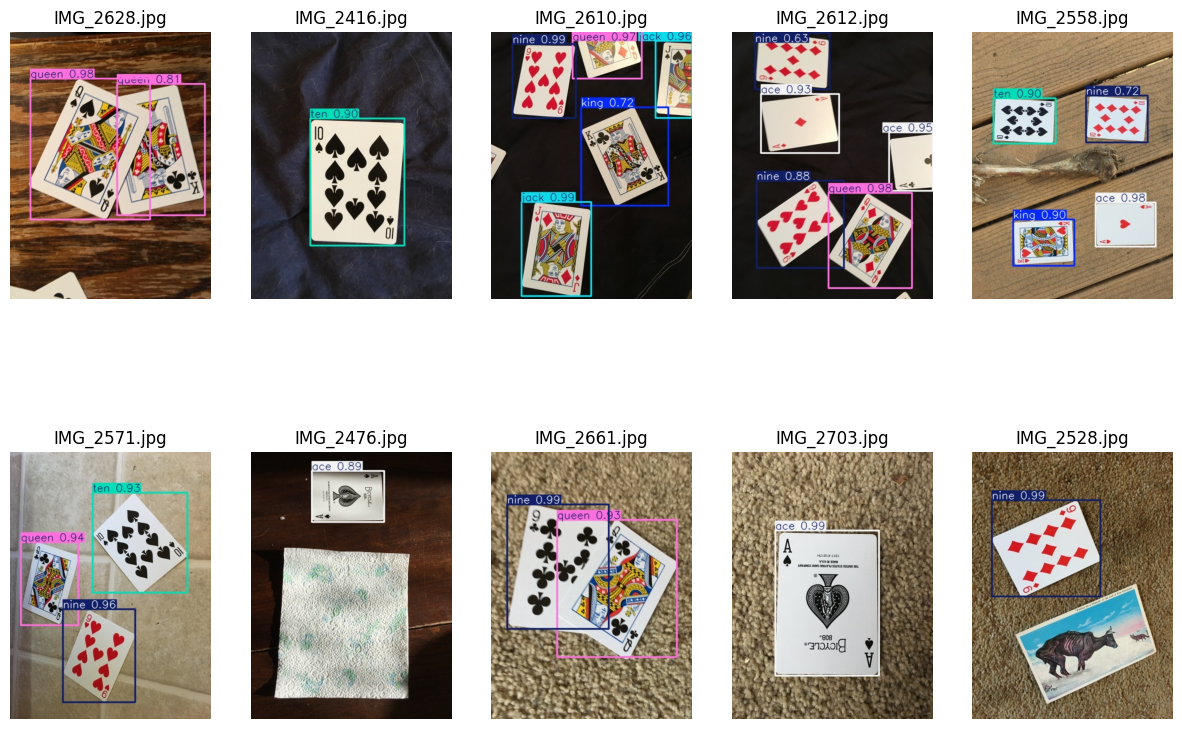

In [99]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

predictions_dir="/Users/luka.markov/git/luka/dl-course-hse-masters/runs/detect/val_preds"
image_files = os.listdir(predictions_dir)[:10]

plt.figure(figsize=(15, 10))

for i, img_file in enumerate(image_files):
    img = mpimg.imread(os.path.join(predictions_dir, img_file))

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_file)

plt.show()

## Бонус (1 балл)

Реализуйте подсчет mAP для самописной модели. Если найдете готовый код на гитхабах -- используйте с указанием ссылок :)

Сравните свою модель с YOLO11. Что получается?